# Spatial Analysis of Crime in Leeds (June–November 2025)

## Introduction
This project investigates the spatial distribution of recorded street-level crime in Leeds using open data from the UK Police API and official boundary datasets. The main aim is to explore spatial patterns of crime at the LSOA level and visualise differences in crime intensity across the city.



## Method Overview

The overall workflow of this study includes data collection, data cleaning, spatial processing, aggregation, and visualisation. Monthly street-level crime data were first collected from the UK Police API. Spatial boundary data for Leeds LSOAs were then loaded and prepared. After cleaning and geocoding the crime records, a spatial join was performed to assign crime points to LSOA polygons. Crime counts and densities were calculated and visualised using choropleth maps.


## 1. Data Preparation
This section loads the spatial boundary datasets (LSOA and LAD) and selects the Leeds local authority area.

## Data Sources

- UK Police API: monthly street-level crime data.
- Office for National Statistics (ONS): LSOA and LAD boundary datasets.



In [ ]:
import geopandas as gpd

lsoa = gpd.read_file("LSOA_2011_EW_BGC_V3.shp")
print(lsoa.columns)
lsoa.head()

Index(['LSOA11CD', 'LSOA11NM', 'LSOA11NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.5181,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.5187,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.5218,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.25 182..."
3,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.5145,4ddaf5e4-e47f-4312-89a0-923ffec028a6,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.5388,1c04702a-b662-4cfc-aab9-2c3e0f2d5e29,"POLYGON ((545122.049 184314.931, 545271.849 18..."


In [ ]:
lad = gpd.read_file("LAD_DEC_2021_UK_BGC.shp")
print(lad.columns)
lad.head()


Index(['LAD21CD', 'LAD21NM', 'LAD21NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'geometry'],
      dtype='object')


,LAD21CD,LAD21NM,LAD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,634ed5ff-6f25-4851-ab96-d2f274fc08ed,"MULTIPOLYGON (((450153.6 525935.876, 450139.43..."
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,ae7dc016-2827-46d6-a04a-dd2cd4b35e62,"MULTIPOLYGON (((446860 517200.3, 446854.689 51..."
2,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.5675,9aec84b2-db0c-4d0f-9595-b591f413c49d,"MULTIPOLYGON (((451747.397 520561.1, 451787.40..."
3,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.5569,7b090827-22d3-4f97-8f8f-1624626fe205,"MULTIPOLYGON (((447214.196 517857.904, 447186...."
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,26b7e15d-5fa5-4e26-9388-99829299b27f,"POLYGON ((423475.701 524731.597, 423497.204 52..."


### Select Leeds LAD boundary
The Leeds Local Authority District (LAD) boundary was extracted for use as the study area.


Leeds LAD count: 1


<Axes: >

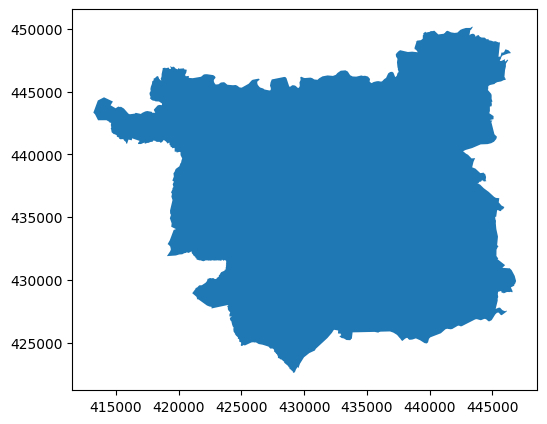

In [ ]:
leeds_lad = lad[lad["LAD21NM"] == "Leeds"].copy()

print("Leeds LAD count:", len(leeds_lad))
leeds_lad.plot(figsize=(6,6))


## 2. Spatial Boundary Processing

### Clip LSOAs to the Leeds boundary
LSOAs were clipped to the Leeds LAD boundary using an intersection overlay to create the analysis units for Leeds.

Number of LSOAs within Leeds: 535


Text(0.5, 1.0, 'LSOAs within Leeds (clipped by LAD boundary)')

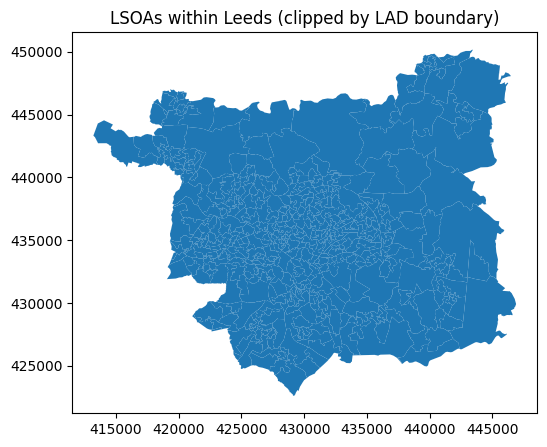

In [ ]:
# Clip LSOAs to the Leeds LAD boundary (core GIS operation)

# Ensure CRS consistency
leeds_lad = leeds_lad.to_crs(lsoa.crs)

# Clip/intersect LSOAs within Leeds boundary
leeds_lsoa = gpd.overlay(lsoa, leeds_lad, how="intersection")

print("Number of LSOAs within Leeds:", len(leeds_lsoa))

ax = leeds_lsoa.plot(figsize=(6, 6))
ax.set_title("LSOAs within Leeds (clipped by LAD boundary)")


### Prepare boundary geometry for API query
The Leeds boundary was converted to WGS84 and simplified to support API queries. In practice, a bounding-box polygon was used for stable data collection.


In [ ]:
from shapely.geometry import Polygon

# Convert Leeds LSOAs to WGS84 (required by Police API)
leeds_lsoa_wgs84 = leeds_lsoa.to_crs(4326)

# Dissolve all LSOAs into a single geometry
try:
    leeds_union = leeds_lsoa_wgs84.geometry.union_all()
except Exception:
    leeds_union = leeds_lsoa_wgs84.unary_union

# Simplify geometry to reduce complexity
outline_simplified = leeds_union.simplify(tolerance=0.003, preserve_topology=True)

# Build a bounding-box polygon for stable API querying
minx, miny, maxx, maxy = outline_simplified.bounds
poly_rect = f"{miny},{minx}:{maxy},{minx}:{maxy},{maxx}:{miny},{maxx}:{miny},{minx}"

print("Bounding box polygon preview:")
print(poly_rect[:120])


Bounding box polygon preview:
53.698967517935564,-1.8004213715842354:53.94587146342933,-1.8004213715842354:53.94587146342933,-1.2903515457861556:53.69


### Test API query
Some test API requests were run to check that the query format worked and returned data. These tests helped confirm that a simple bounding-box polygon was more stable than a complex boundary polygon.

In [ ]:
import math
from shapely.geometry import Polygon, MultiPolygon

# Use Leeds LAD boundary (simpler & more stable than dissolved LSOAs for API calls)
leeds_lad_wgs84 = leeds_lad.to_crs(4326)

try:
    leeds_geom = leeds_lad_wgs84.geometry.union_all()
except Exception:
    leeds_geom = leeds_lad_wgs84.unary_union

def get_largest_polygon(geom):
    if isinstance(geom, Polygon):
        return geom
    if isinstance(geom, MultiPolygon):
        return max(list(geom.geoms), key=lambda g: g.area)
    raise TypeError("Geometry must be Polygon or MultiPolygon.")

outline = get_largest_polygon(leeds_geom)

# Simplify first (tolerance in degrees); 0.01 is ~1km, usually still fine for city-level boundary
outline_simplified = outline.simplify(tolerance=0.01, preserve_topology=True)

def polygon_to_police_poly(poly, max_points=100):
    """
    Police API poly format:
    lat,lon:lat,lon:lat,lon...
    Also downsample vertices to max_points to avoid API 400 errors.
    """
    coords = list(poly.exterior.coords)

    # Downsample vertices
    if len(coords) > max_points:
        step = math.ceil(len(coords) / max_points)
        coords = coords[::step]

    # Ensure closure
    if coords[0] != coords[-1]:
        coords.append(coords[0])

    return ":".join([f"{lat},{lon}" for lon, lat in coords])

poly_string_api = polygon_to_police_poly(outline_simplified, max_points=100)

print("Vertex count used:", poly_string_api.count(":") + 1)
print("Poly string length:", len(poly_string_api))
print("Preview:", poly_string_api[:200])


Vertex count used: 31
Poly string length: 1174
Preview: 53.94251884452835,-1.397176450953895:53.92704694791132,-1.294174854795854:53.921477121656864,-1.307304534549538:53.90746819993601,-1.3005829269330944:53.9029033913026,-1.3217771258525437:53.8652992228


### Quick single-month test
A simple test query was carried out for a single month to check whether the API request format worked correctly before downloading the full dataset.

In [ ]:
import requests
import pandas as pd

def fetch_crimes_for_poly_debug(poly_str, date_yyyy_mm):
    url = "https://data.police.uk/api/crimes-street/all-crime"
    params = {"poly": poly_str, "date": date_yyyy_mm}
    r = requests.get(url, params=params, timeout=120)

    if r.status_code != 200:
        print("Status:", r.status_code)
        print("Response (first 300 chars):", r.text[:300])
        r.raise_for_status()

    df = pd.DataFrame(r.json())
    df["month"] = date_yyyy_mm
    return df

test_month = "2025-12"
test_df = fetch_crimes_for_poly_debug(poly_string_api, test_month)
print("Test month records:", len(test_df))
test_df.head()


Test month records: 0


,month


#### Bounding-box test (used in final data collection)


In [ ]:
print("Rows in leeds_lad:", len(leeds_lad))
print("Unique LAD names:", leeds_lad["LAD21NM"].unique()[:10])
print("Bounds (WGS84):", leeds_lad.to_crs(4326).total_bounds)


Rows in leeds_lad: 1
Unique LAD names: ['Leeds']
Bounds (WGS84): [-1.80042137 53.69896752 -1.29035155 53.94587146]


In [ ]:
# Build a simple rectangle poly from Leeds LAD bounding box (WGS84)
leeds_wgs84 = leeds_lad.to_crs(4326)
minx, miny, maxx, maxy = leeds_wgs84.total_bounds

# Police poly format: lat,lon:lat,lon:...
poly_rect = f"{miny},{minx}:{miny},{maxx}:{maxy},{maxx}:{maxy},{minx}:{miny},{minx}"
print("Rectangle poly preview:", poly_rect[:120])

test_df = fetch_crimes_for_poly_debug(poly_rect, "2025-12")
print("Test month records (rectangle):", len(test_df))


Rectangle poly preview: 53.698967517935564,-1.8004213715842354:53.698967517935564,-1.2903515457861556:53.94587146342933,-1.2903515457861556:53.9
Test month records (rectangle): 0


## 3. Crime Data Collection from UK Police API
This section retrieves street-level crime records from the UK Police API for the most recent months available.

### Check available months
The API provides crime data by month. Available months were checked before selecting the analysis period.

In [ ]:
import requests
import pandas as pd

# Police API: list available months for street-level crime
dates_url = "https://data.police.uk/api/crimes-street-dates"
available_dates = requests.get(dates_url, timeout=60).json()

dates_df = pd.DataFrame(available_dates)
print("Number of available months:", len(dates_df))
print("Most recent available month:", dates_df["date"].iloc[0])
print("Oldest available month:", dates_df["date"].iloc[-1])

dates_df.head()


Number of available months: 36
Most recent available month: 2025-11
Oldest available month: 2022-12


,date,stop-and-search
0,2025-11,"[bedfordshire, btp, cambridgeshire, cheshire, ..."
1,2025-10,"[avon-and-somerset, bedfordshire, btp, cambrid..."
2,2025-09,"[avon-and-somerset, bedfordshire, btp, cambrid..."
3,2025-08,"[avon-and-somerset, bedfordshire, btp, cambrid..."
4,2025-07,"[avon-and-somerset, bedfordshire, btp, cambrid..."


In [ ]:
latest_6_months = dates_df["date"].head(6).tolist()
print("Selected months:", latest_6_months)


Selected months: ['2025-11', '2025-10', '2025-09', '2025-08', '2025-07', '2025-06']


### Download crime data
Crime data were downloaded for the latest six months available. A retry method was used to handle occasional API server errors.

In [ ]:
import time
import requests
import pandas as pd

def fetch_crimes_for_poly_with_retries(poly_str, date_yyyy_mm, max_retries=6, base_sleep=2):
    """
    Fetch street-level crime data from the UK Police API with retries.
    Retries handle occasional 5xx errors (e.g., 502 Bad Gateway).
    """
    url = "https://data.police.uk/api/crimes-street/all-crime"
    params = {"poly": poly_str, "date": date_yyyy_mm}

    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, params=params, timeout=120)

            # Retry on server-side errors
            if r.status_code in (500, 502, 503, 504):
                raise requests.HTTPError(f"Server error {r.status_code}")

            r.raise_for_status()
            df = pd.DataFrame(r.json())
            df["month"] = date_yyyy_mm
            return df

        except Exception as e:
            wait = base_sleep * (2 ** (attempt - 1))
            print(f"{date_yyyy_mm}: attempt {attempt}/{max_retries} failed ({e}). Retrying in {wait}s...")
            time.sleep(wait)

    # If all retries fail, return empty DataFrame (do not crash the pipeline)
    print(f"{date_yyyy_mm}: all retries failed. Skipping this month for now.")
    return pd.DataFrame()

# Select latest 6 available months from API
latest_6_months = dates_df["date"].head(6).tolist()
print("Selected months:", latest_6_months)

crime_dfs = []
for m in latest_6_months:
    df_m = fetch_crimes_for_poly_with_retries(poly_rect, m)
    print(f"{m}: {len(df_m):,} crime records")
    crime_dfs.append(df_m)
    time.sleep(1.5)

crimes = pd.concat([d for d in crime_dfs if len(d) > 0], ignore_index=True)
print("Total crime records:", len(crimes))

crimes.to_csv("leeds_crimes_6months_raw.csv", index=False)



Selected months: ['2025-11', '2025-10', '2025-09', '2025-08', '2025-07', '2025-06']
2025-11: 14,827 crime records
2025-10: attempt 1/6 failed (Server error 502). Retrying in 2s...
2025-10: 15,996 crime records
2025-09: 15,576 crime records
2025-08: 16,404 crime records
2025-07: attempt 1/6 failed (Server error 504). Retrying in 2s...
2025-07: 17,163 crime records
2025-06: 16,220 crime records
Total crime records: 96186


## 4. Spatial Join and Aggregation
Crime points were converted into a GeoDataFrame and spatially joined to Leeds LSOAs. Crime counts were then aggregated for each LSOA. This allowed crime incidents to be analysed at a neighbourhood scale.

### Data Cleaning
Records without valid geographic coordinates were removed to ensure that all remaining crime points could be correctly mapped and spatially joined to LSOA boundaries.

In [ ]:
import numpy as np
import geopandas as gpd

# Remove missing location entries
crimes = crimes.dropna(subset=["location"]).copy()

# Extract lon/lat
crimes["longitude"] = crimes["location"].apply(
    lambda x: float(x["longitude"]) if isinstance(x, dict) and x.get("longitude") else np.nan
)
crimes["latitude"] = crimes["location"].apply(
    lambda x: float(x["latitude"]) if isinstance(x, dict) and x.get("latitude") else np.nan
)

crimes = crimes.dropna(subset=["longitude", "latitude"]).copy()

# Create GeoDataFrame of crime pointss
crime_gdf = gpd.GeoDataFrame(
    crimes,
    geometry=gpd.points_from_xy(crimes["longitude"], crimes["latitude"]),
    crs="EPSG:4326"
)

# Spatial join to Leeds LSOAs
leeds_lsoa_wgs84 = leeds_lsoa.to_crs(4326)

crime_joined = gpd.sjoin(
    crime_gdf,
    leeds_lsoa_wgs84[["LSOA11CD", "LSOA11NM", "geometry"]],
    how="inner",
    predicate="within"
)

print("Crimes assigned to Leeds LSOAs:", len(crime_joined))
crime_joined.head()


Crimes assigned to Leeds LSOAs: 56023


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,longitude,latitude,geometry,index_right,LSOA11CD,LSOA11NM
0,anti-social-behaviour,Force,"{'latitude': '53.794351', 'street': {'id': 212...",,None,,132248448,,2025-11,-1.388339,53.794351,POINT (-1.38834 53.79435),152,E01011396,Leeds 074A
1,anti-social-behaviour,Force,"{'latitude': '53.737704', 'street': {'id': 212...",,None,,132247650,,2025-11,-1.533517,53.737704,POINT (-1.53352 53.7377),247,E01011499,Leeds 105C
4,anti-social-behaviour,Force,"{'latitude': '53.740158', 'street': {'id': 211...",,None,,132247533,,2025-11,-1.614601,53.740158,POINT (-1.6146 53.74016),280,E01011534,Leeds 106B
6,anti-social-behaviour,Force,"{'latitude': '53.801452', 'street': {'id': 211...",,None,,132247503,,2025-11,-1.636116,53.801452,POINT (-1.63612 53.80145),348,E01011608,Leeds 068A
7,anti-social-behaviour,Force,"{'latitude': '53.810734', 'street': {'id': 212...",,None,,132247502,,2025-11,-1.522486,53.810734,POINT (-1.52249 53.81073),409,E01011673,Leeds 064B


### Calculate crime count and density
Crime counts were summarised for each LSOA. Crime density was calculated using LSOA area (km²) to account for differences in polygon size, allowing fair comparison between neighbourhoods of different sizes.

A spatial join was applied to assign each crime point to the LSOA polygon in which it occurred, allowing crime counts to be aggregated at the neighbourhood level.

In [ ]:
# Aggregate counts per LSOA
crime_counts = (
    crime_joined
    .groupby(["LSOA11CD", "LSOA11NM"])
    .size()
    .rename("crime_count")
    .reset_index()
)

# Join back to Leeds LSOA polygons
leeds_lsoa_stats = leeds_lsoa.merge(
    crime_counts, on=["LSOA11CD", "LSOA11NM"], how="left"
)

leeds_lsoa_stats["crime_count"] = leeds_lsoa_stats["crime_count"].fillna(0).astype(int)

# Calculate area and density (use British National Grid for accurate area)
leeds_lsoa_stats_bng = leeds_lsoa_stats.to_crs(27700)
leeds_lsoa_stats["area_km2"] = leeds_lsoa_stats_bng.area / 1e6
leeds_lsoa_stats["crime_density_per_km2"] = (
    leeds_lsoa_stats["crime_count"] / leeds_lsoa_stats["area_km2"]
)

leeds_lsoa_stats[
    ["LSOA11CD", "crime_count", "area_km2", "crime_density_per_km2"]
].head()


,LSOA11CD,crime_count,area_km2,crime_density_per_km2
0,E01010573,0,0.005431,0.0
1,E01010610,0,0.001351,0.0
2,E01010612,0,0.000004,0.0
3,E01010618,0,0.002995,0.0
4,E01010623,0,0.000002,0.0


## 5. Mapping and Visualisation
Two choropleth maps were produced to show the spatial pattern of crime count and crime density across Leeds. These maps help to visually identify high-crime and low-crime areas across the city.

Choropleth maps were produced to visualise the spatial distribution of crime counts and crime density across Leeds LSOAs.

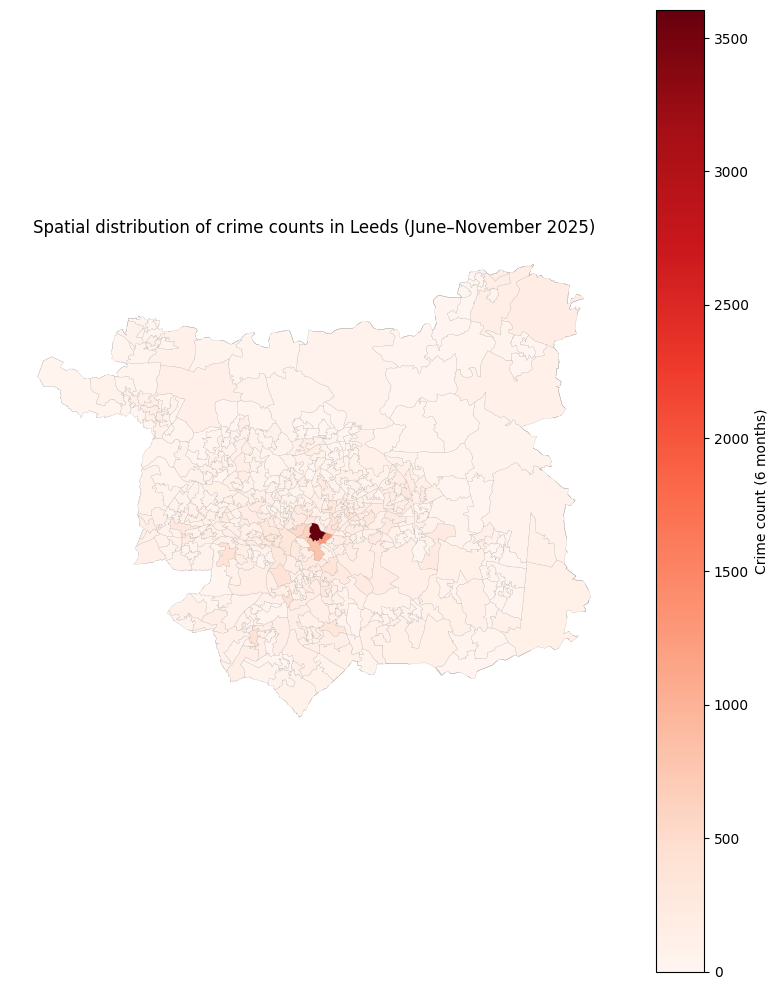

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

leeds_lsoa_stats.plot(
    column="crime_count",
    cmap="Reds",
    linewidth=0.1,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Crime count (6 months)"}
)

ax.set_title("Spatial distribution of crime counts in Leeds (June–November 2025)")
ax.axis("off")

plt.tight_layout()
plt.show()


This map shows the total number of recorded crimes in each LSOA in Leeds between June and November 2025.

Areas in darker red represent LSOAs with a higher number of crimes, while lighter colours indicate lower crime counts. The results show that crime incidents are strongly concentrated in the city centre, where commercial activities, nightlife, transport hubs and higher population flows are located. In contrast, outer suburban areas generally record much lower crime counts.

This spatial pattern suggests that crime is closely related to human activity intensity and land use, with central areas experiencing more opportunities for crime.

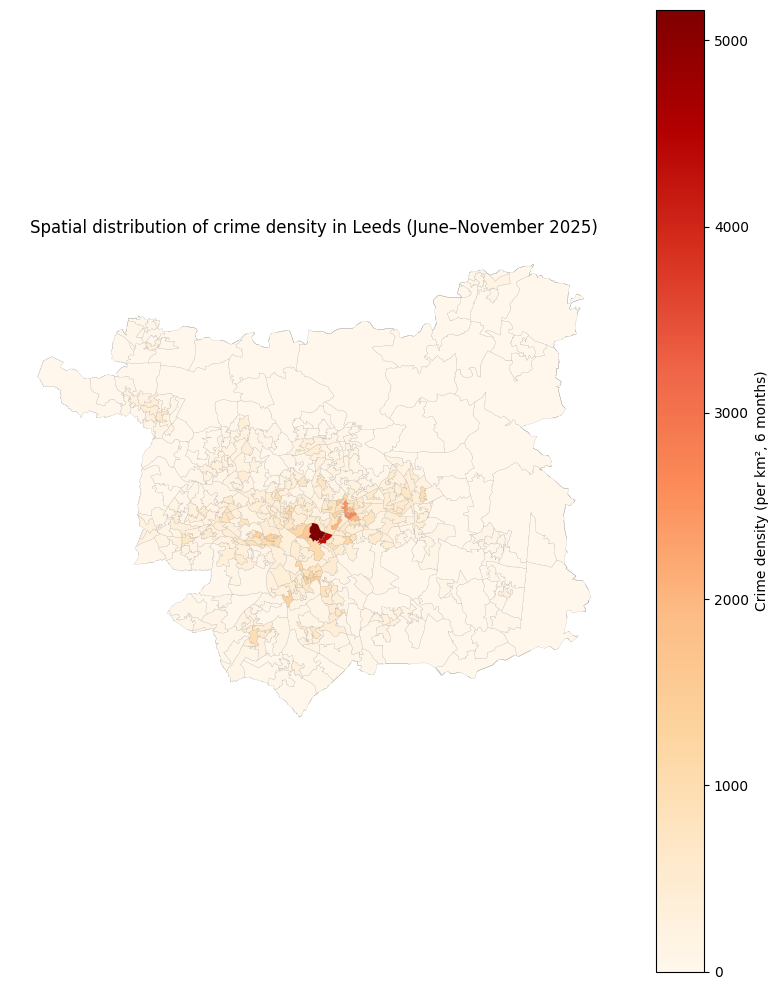

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

leeds_lsoa_stats.plot(
    column="crime_density_per_km2",
    cmap="OrRd",
    linewidth=0.1,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Crime density (per km², 6 months)"}
)

ax.set_title("Spatial distribution of crime density in Leeds (June–November 2025)")
ax.axis("off")

plt.tight_layout()
plt.show()


This map presents the crime density (crimes per square kilometre) across Leeds LSOAs for the same period.

Compared with the crime count map, the density map highlights small central areas with extremely high crime intensity. These LSOAs cover relatively small geographic areas but contain a large number of crime incidents, leading to very high crime density values. This is particularly evident in the central business district.

Using crime density helps to reduce the influence of area size and allows a fairer comparison between LSOAs of different sizes. As a result, this map provides a clearer view of true crime hotspots, rather than simply large areas with high totals.

## Results Interpretation
The maps show that crime is unevenly distributed across Leeds. Higher crime counts and densities are mainly concentrated in the city centre and surrounding inner urban areas, while suburban and peripheral areas generally exhibit lower levels of crime. This pattern is consistent with expectations, as central areas typically have higher population density, commercial activity, and transport connectivity, which are associated with increased opportunities for crime. These results highlight clear spatial inequalities in crime distribution across the city.


## 6. Conclusion

This study analysed the spatial distribution of street-level crime in Leeds using police open data and GIS-based spatial analysis techniques. Crime incidents from June to November 2025 were collected via the UK Police API and spatially joined to Lower Layer Super Output Areas (LSOAs) within the Leeds local authority boundary. By combining spatial data processing, spatial joins and mapping, the project aimed to identify spatial patterns of crime across the city.

The results indicate that crime is not evenly distributed across Leeds. Both crime count and density maps show clear concentrations in central Leeds, particularly in the city centre and surrounding inner urban areas. In contrast, suburban and peripheral areas generally exhibit much lower crime levels. This spatial pattern is consistent with expectations, as central areas typically have higher population density, greater commercial activity, and stronger transport connectivity, all of which are commonly associated with increased crime opportunities. The comparison between crime counts and crime density also highlights the importance of considering area size, as small central LSOAs tend to show extremely high crime intensity.

Overall, the analysis demonstrates how GIS techniques can be effectively applied to explore urban crime patterns. Although the study is limited by the relatively short time period and reliance on recorded crime data, the workflow provides a clear and practical framework for future analysis. Further research could extend this approach by using longer time series, analysing specific crime categories, or incorporating socio-economic indicators to gain deeper insights into the factors influencing crime distribution in Leeds.

## References

- UK Police API (2025). Street-level crime data. https://data.police.uk/docs/
- Office for National Statistics (ONS) (2021). LSOA and LAD boundary datasets. https://geoportal.statistics.gov.uk/
- GeoPandas documentation: https://geopandas.org/
